# **Final Project: Task 1**

## Preprocessing and Topic Modeling of Reddit dataset

### Machine Learning Applications - Universidad Carlos III de Madrid


---

**Authors:**
- Enrique Botía Barberá 
- David Méndez Encinas 
- Andrés Ruiz Calvo 
- Simón E. Sánchez Viloria

In [ ]:
# Common imports 

import numpy as np
import pandas as pd
import zipfile as zp
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
from fastprogress import progress_bar
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

#For fancy table Display
%load_ext google.colab.data_table

#helper function for plotting subplots
!pip install git+git://github.com/simonsanvil/subplotted.git
from subplotted import subplotted

  Cloning git://github.com/simonsanvil/subplotted.git to /tmp/pip-req-build-1u7j6uhz
  Running command git clone -q git://github.com/simonsanvil/subplotted.git /tmp/pip-req-build-1u7j6uhz
  Created wheel for subplotted: filename=subplotted-0.1.0-cp37-none-any.whl size=2619 sha256=1b9beb12e190e311ab30ef9b6d7906661b8dc6575bef33f22bcc90fd9a74262e
  Stored in directory: /tmp/pip-ephem-wheel-cache-10cobi2_/wheels/92/9c/47/8b33b2b9966e9d98e298f88695373aaec5a7afb2359bd532f0
Successfully built subplotted


In [ ]:
#To wrap long text lines
from IPython.display import HTML, display

def set_css():
  display(HTML('''<style>pre { white-space: pre-wrap;}</style>'''))
get_ipython().events.register('pre_run_cell', set_css)

### *1. Analysing the dataset*

We will extract some characteristics of the dataset:

In [ ]:
reddit_df = pd.read_excel("https://storage.googleapis.com/enver-bucket/data/reddit_posts_df_2.xlsx")
reddit_df.drop_duplicates(subset=['title','subreddit','text'],inplace=True)
reddit_df.head(1)

,title,text,score,subreddit,url
0,3 Days of Inpatient Care in New York,Day 1.\n\n3 COVID cases in a census of 14 (one...,4841,medicine,https://www.reddit.com/r/medicine/comments/fp2...


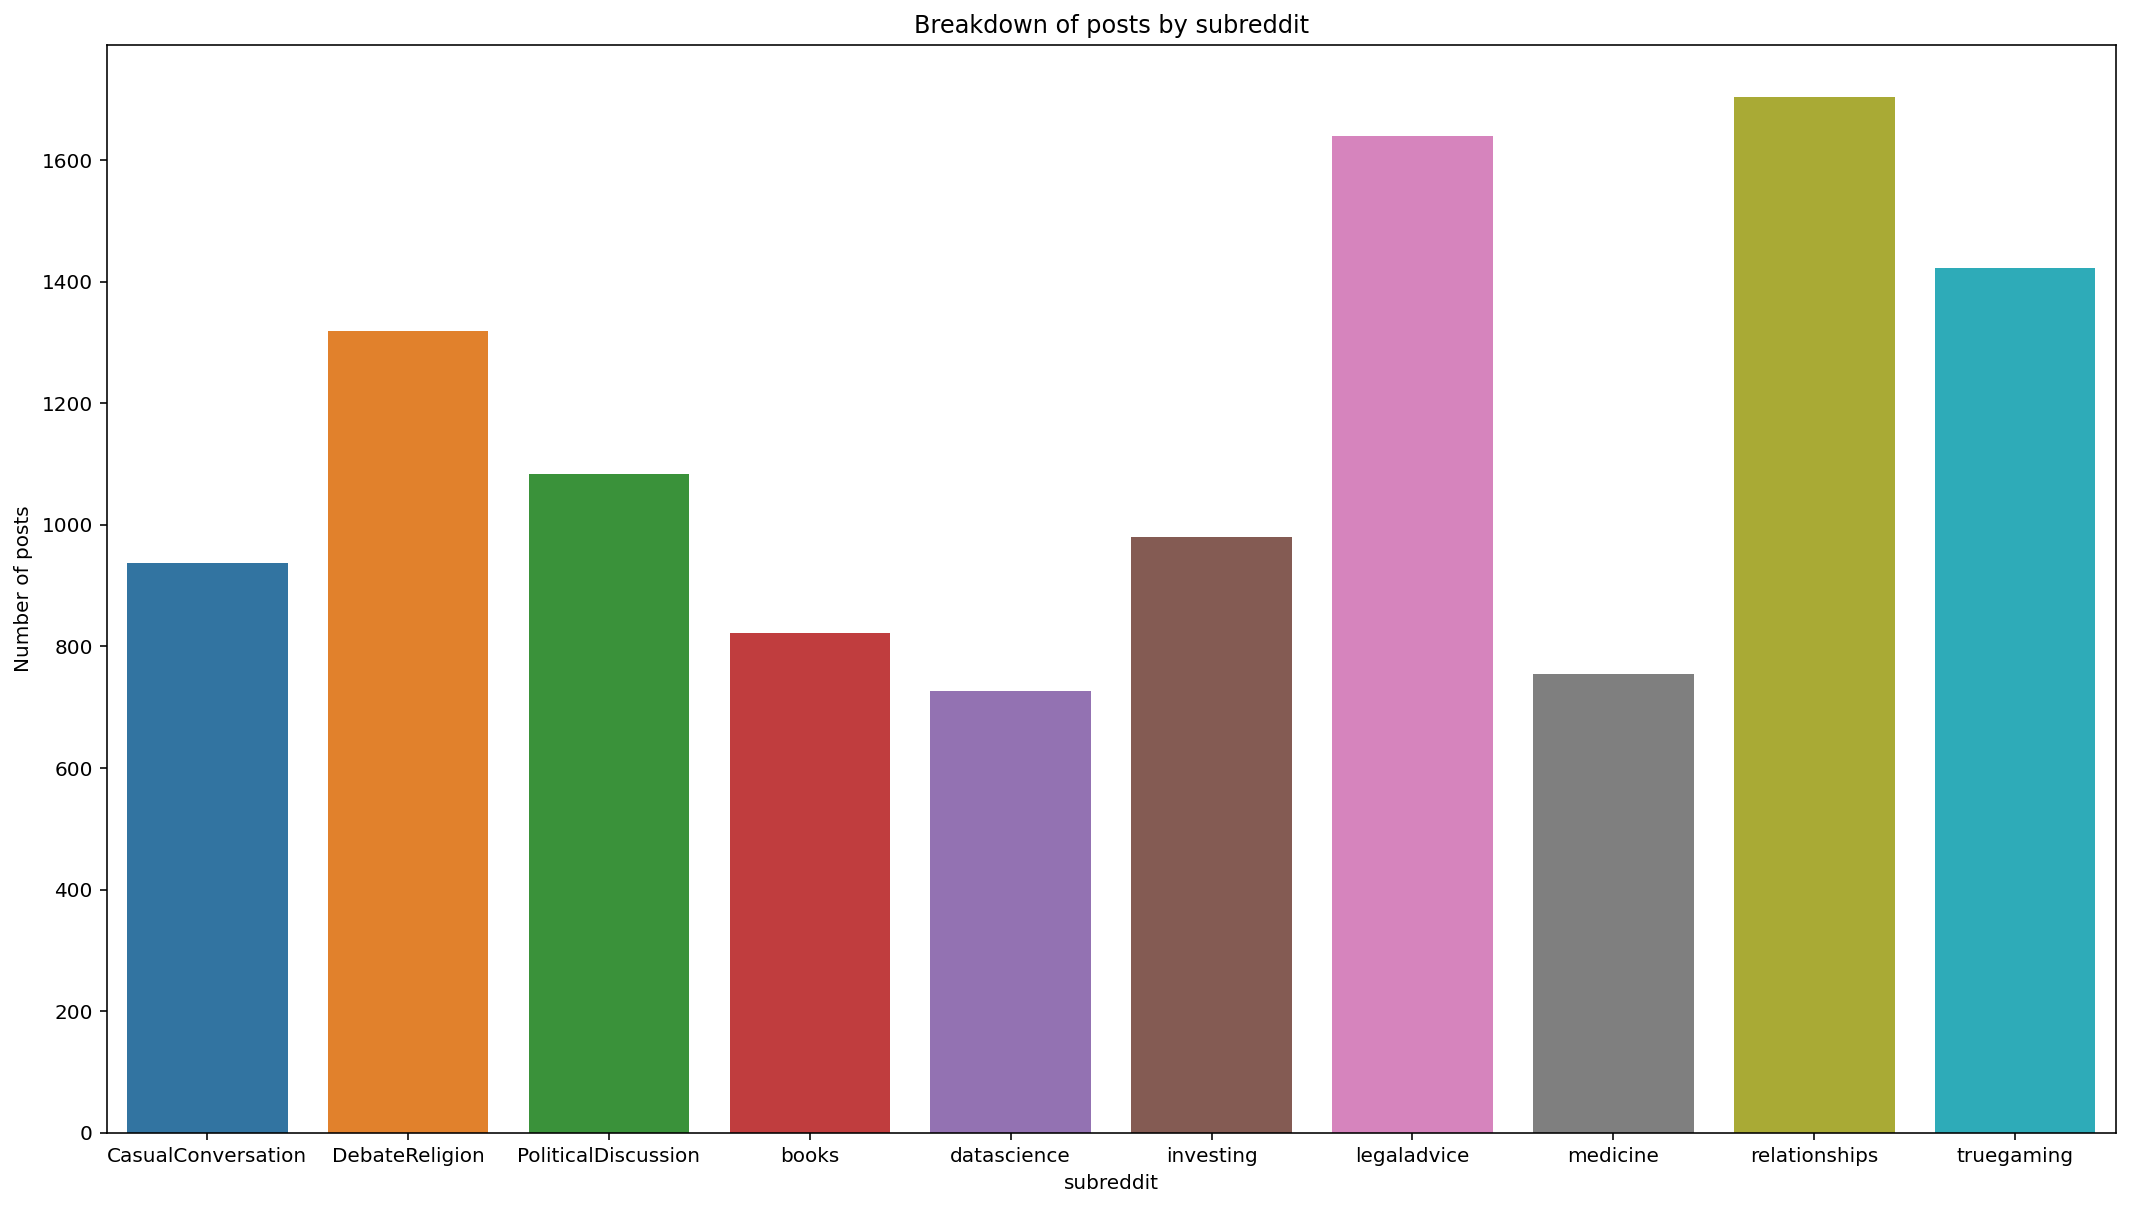

In [ ]:
plt.figure(figsize=(18,10))
sns.barplot(data=reddit_df.value_counts("subreddit").reset_index().sort_values("subreddit"), y=0,x='subreddit').set(title='Breakdown of posts by subreddit',ylabel="Number of posts")
plt.show()

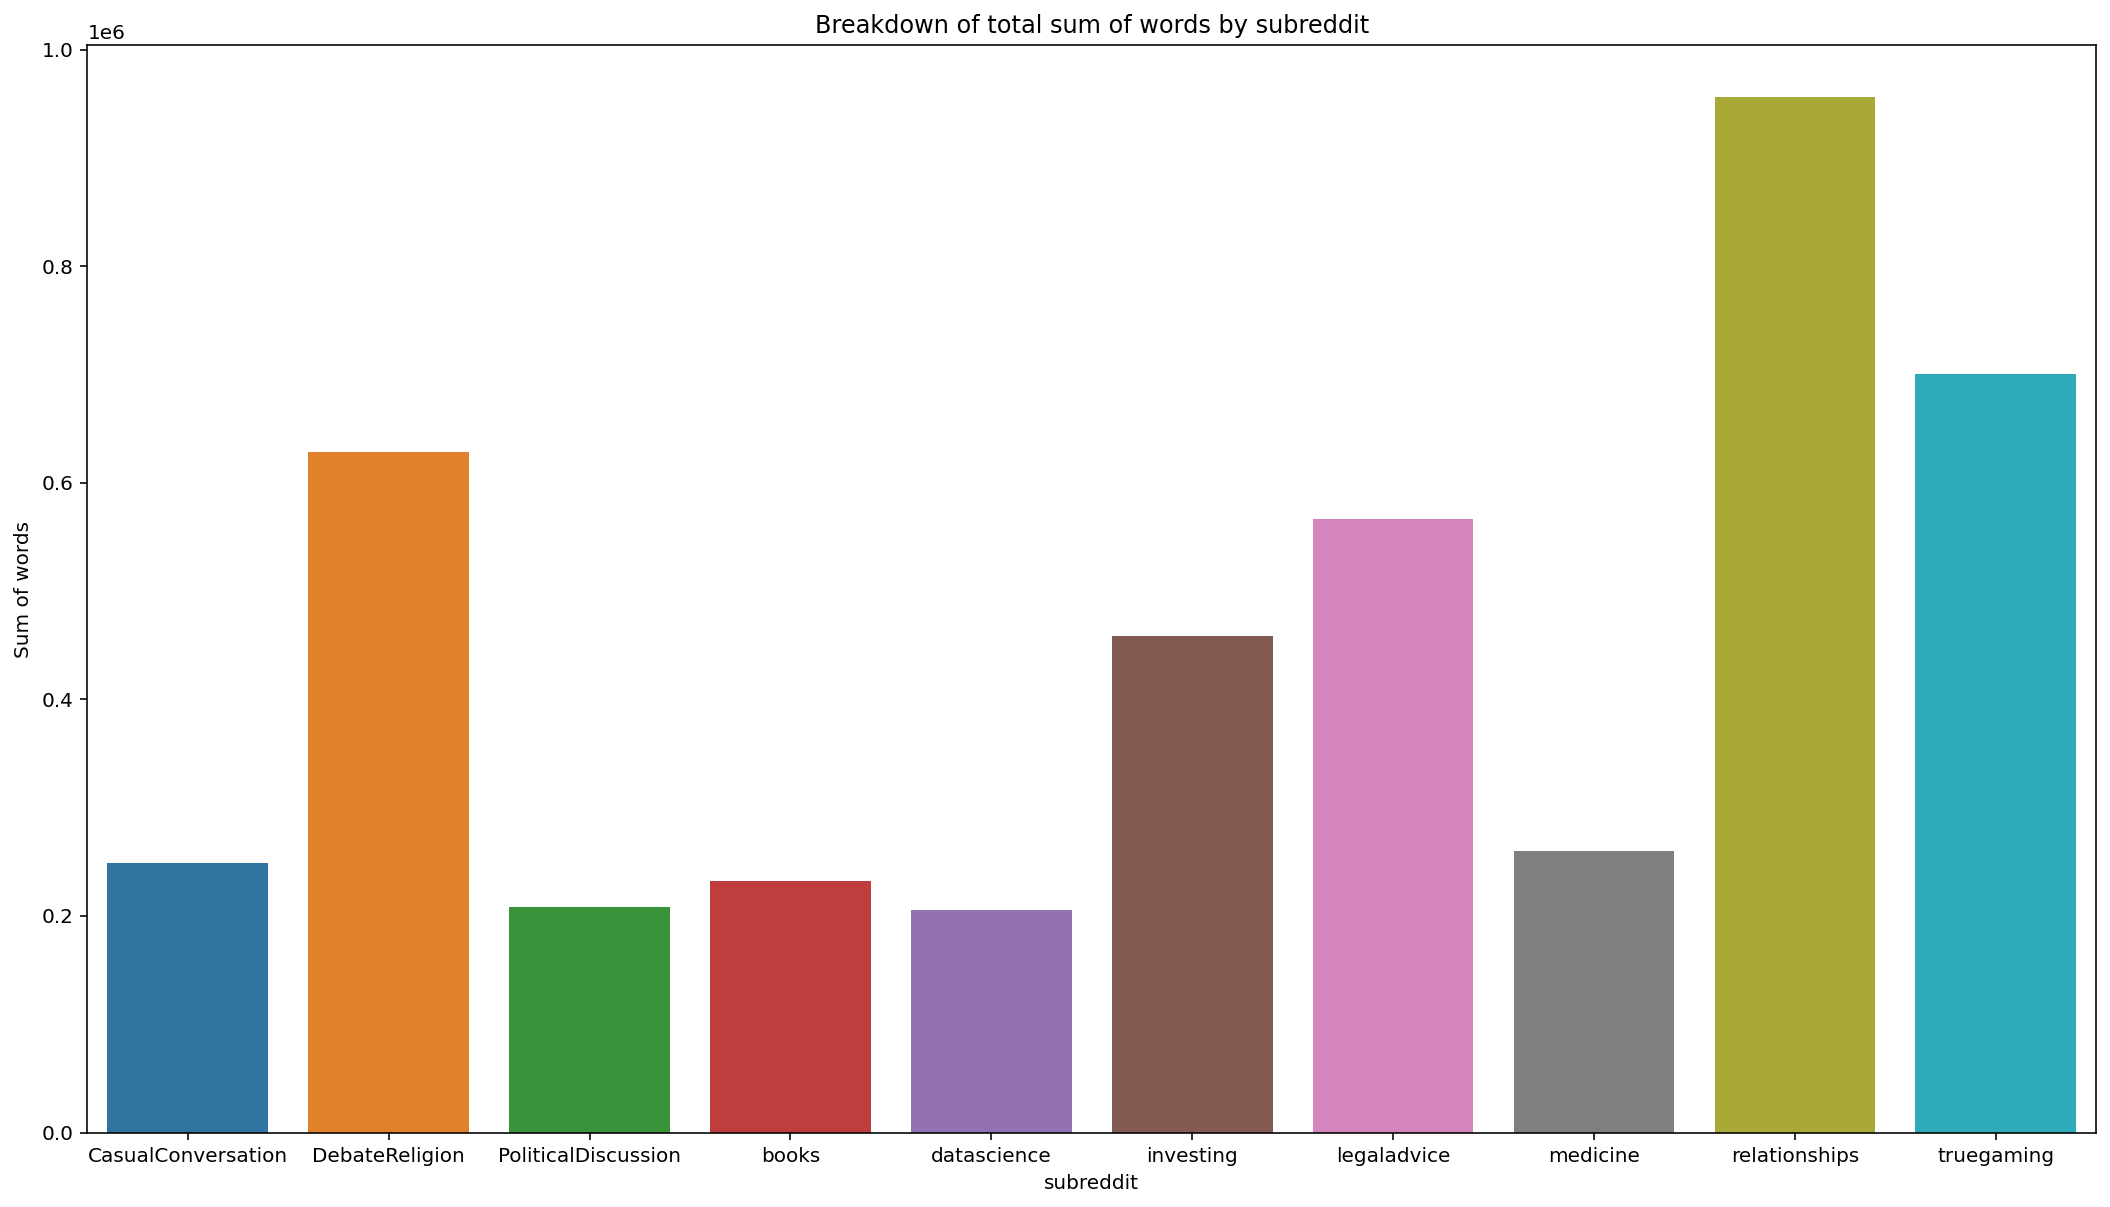

In [ ]:
plt.figure(figsize=(18,10))
sns.barplot(x ="subreddit", y="num_words",
    data = reddit_df
    .assign(num_words=reddit_df.text.str.split(' ').str.len())[['subreddit','num_words']]
    .groupby('subreddit')
    .agg(sum)
    .reset_index()
    .sort_values("subreddit")
).set(title='Breakdown of total sum of words by subreddit',ylabel="Sum of words")
plt.show()

## **2. Text Preprocessing and Topic Modeling**
---

### *2.1. Installing and Updating Python Libraries*

In [ ]:
%%capture

!pip install --upgrade spacy
import spacy
!python -m spacy download en_core_web_md

!python -m spacy download xx_sent_ud_sm
!pip install --upgrade spacy_langdetect

!pip install --upgrade gensim==3.8.3
!pip install pyLDAvis==2.1.2

import nltk

import os       #import os to set environment variable
def install_java():
    !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
    !java -version       #check java version
install_java()

!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

os.environ['MALLET_HOME'] = 'mallet-2.0.8'
mallet_path = 'mallet-2.0.8/bin/mallet' # you should NOT need to change this

#constant that we will use later
MIN_LEMMAS = 20

### *2.2. Preprocessing*

We will implement a pipeline for the preprocessing of the texts of the Reddit posts.

In [ ]:
import nltk
nltk.download('words')
nlp = spacy.load('en_core_web_md')

#variables used to filter the tokens
english_words = set(nltk.corpus.words.words())
valid_POS = set(['VERB', 'NOUN', 'ADJ', 'PROPN'])
specific_stw = set(['relevant', 'simple', 'base','na','edit','tldr','user','comment','post']) 
def text_preprocessing(rawtext):
    """
    Implements tokenization, lemmatization and stopword removal from a string
    :rawtext: Input string to preprocess
    
    Returns the lemmatized string where lemmas are joined with a blank space
    """
    # 1. Sentence tokenization and filtering of non-English sentences
    doc = nlp(rawtext)
    doc = [token for token in doc if token.text.lower() in english_words]
    # 2. Keep only alphanumeric tokens
    doc = [token for token in doc if token.is_alpha]
    # 3. Keep nouns, verbs, and adjectives
    doc = [token for token in doc if token.pos_ in valid_POS]
    # 4. Generic Stopword removal
    doc = [token for token in doc if not token.is_stop]
    # 5. Specific Stopword removal
    doc = [token for token in doc if token.text.lower() not in specific_stw]
    # 6. Lemmatization
    lemmatized = " ".join([token.lemma_ for token in doc])
    return lemmatized

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
REDDIT_lemmas = []
nposts = reddit_df.shape[0]

for n, post in enumerate(progress_bar(reddit_df.text)):
    if not n%100:
        print('\rPreprocessing abstract', n, 'out of', nposts, end='', flush=True)
    REDDIT_lemmas.append(text_preprocessing(post))

Preprocessing abstract 11400 out of 11415

This took some time ... let us store the Dataframe in the local folder.

In [ ]:
# Storing the data as a dataframe
reddit_df['lemmas'] = REDDIT_lemmas
reddit_df['lemmas'] = reddit_df['lemmas'].str.lower()
reddit_df[['title','subreddit','text','lemmas']].sample(3)

,title,subreddit,text,lemmas
3894,Donald Trump has pardoned Scooter Libby for hi...,PoliticalDiscussion,"So, Donald Trump formally issued a pardon to L...",trump pardon today president trump scooter bus...
5822,Argument For A Cover-Up In Christianity,DebateReligion,\n\nA covenant is an agreement made between ...,covenant agreement speak humankind god example...
702,"Doctors, Your Deaf Patients Want To Know What ...",medicine,****LINK TO ORIGINAL POST is below the text***...,link original text lewis dear write letter enl...


In [ ]:
local_folder = 'data/'
reddit_df.to_excel(local_folder+'REDDIT_lemmas_df.xlsx',index=False)

### *2.3. Vectorization*

#### 2.3.1. Analysis of the lemmas and filtering by the number of lemmas in each document.


**Analysis of the frequency of lemmas in each forum:**

In [ ]:
reddit_df = pd.read_excel("https://storage.googleapis.com/enver-bucket/data/REDDIT_lemmas_df.xlsx")

In [ ]:
topwords = {}
for subr in reddit_df.subreddit.unique():
  topw = reddit_df[reddit_df.subreddit==subr]['lemmas'].str.split(" ").explode().value_counts().sort_values(ascending=False).head(500).index.tolist()
  topwords[subr] = topw
  print(f"\n- Most frequent words in r/{subr}:\n{', '.join(topw[:30] )}")


- Most frequent words in r/medicine:
patient, know, time, medical, work, people, day, go, think, care, good, hospital, feel, get, come, need, medicine, want, tell, find, covid, try, see, health, say, school, year, help, way, physician

- Most frequent words in r/books:
book, read, think, time, know, people, feel, story, good, find, way, love, go, write, work, life, get, come, world, lot, try, finish, want, man, end, series, day, novel, character, new

- Most frequent words in r/datascience:
data, datum, work, science, time, know, think, people, job, good, learn, company, want, model, use, need, scientist, experience, python, learning, look, find, lot, get, feel, team, way, machine, go, new

- Most frequent words in r/truegaming:
game, time, think, people, feel, good, play, way, player, world, know, go, find, story, want, lot, new, come, try, get, gaming, character, bad, look, different, point, need, experience, work, thing

- Most frequent words in r/PoliticalDiscussion:
trump, presid

In [ ]:
#get words that appear in the most frequents of all subreddits. These could be considered as stopwords in the final processing
common_frequents = set()
for subr in reddit_df.subreddit.unique():
  if len(common_frequents) == 0:
    common_frequents = common_frequents.union(topwords[subr])
  else:
    common_frequents = common_frequents.intersection(topwords[subr])
print('Frequent words in all subreddits: ',', '.join(common_frequents))

Frequent words in all subreddits:  say, point, great, bad, leave, time, real, rest, share, continue, see, think, kind, line, lead, high, want, lot, stop, come, support, add, hard, possible, mind, try, live, fact, idea, social, case, need, work, end, job, small, like, tell, care, give, talk, order, feel, today, run, take, year, clear, let, consider, bring, long, well, look, make, number, spend, r, use, sure, head, old, short, decide, help, list, start, understand, set, past, free, good, face, note, write, pay, hand, second, right, people, thing, little, open, place, new, turn, read, group, life, get, mean, personal, deal, similar, wrong, believe, break, go, reason, lose, day, change, way, happen, state, big, future, different, single, able, find, follow, know, problem


**Analysis of the number of lemmas:**

The average number of tokens per document is 109.87489025460931


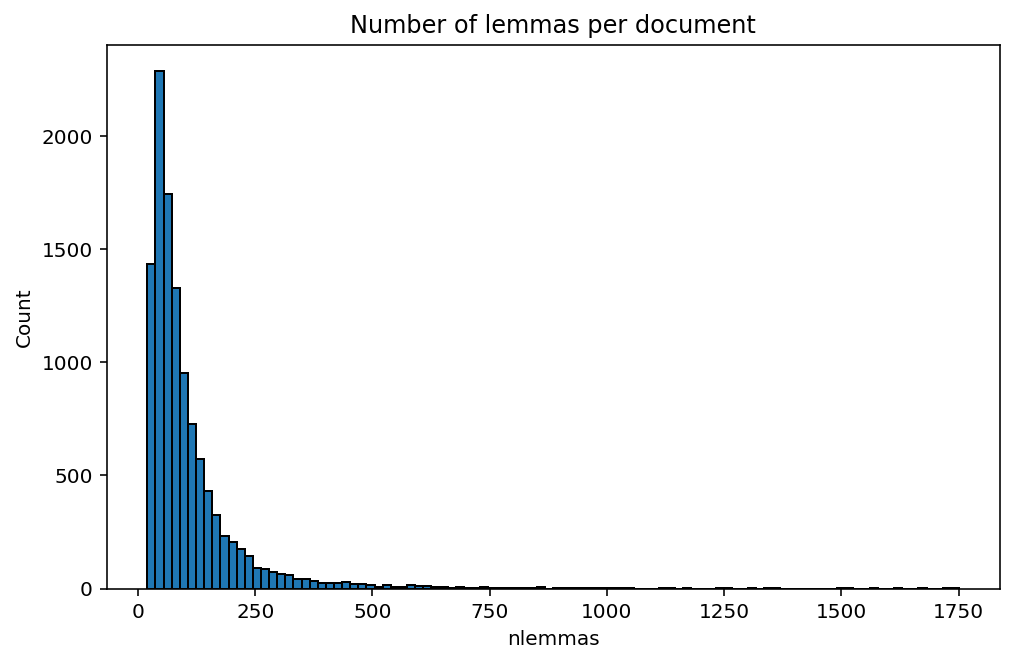

In [ ]:
reddit_df['nlemmas'] = reddit_df["lemmas"].str.split(" ").str.len()
print("The average number of tokens per document is", np.mean(reddit_df['nlemmas']))
plt.figure(figsize=(8,5))
plt.hist(reddit_df['nlemmas'], bins=100, ec='black')
plt.title("Number of lemmas per document")
plt.xlabel("nlemmas")
plt.ylabel("Count");

In the light of these values, we arbitrarily set a threshold on the number of lemmas:

In [ ]:
print('Number of projects in DataFrame before removing short posts:', len(reddit_df))
print('Number of rows per subreddit before removing short posts:')
display(reddit_df.value_counts("subreddit"))
reddit_df = reddit_df[reddit_df['nlemmas']>=20]
print('\nNumber of projects in DataFrame after removing short posts:', len(reddit_df))
print('Number of rows per subreddit after removing short posts:')
display(reddit_df.value_counts("subreddit"))

Number of projects in DataFrame before removing short posts: 11390
Number of rows per subreddit before removing short posts:


subreddit
relationships          1704
legaladvice            1640
truegaming             1423
DebateReligion         1320
PoliticalDiscussion    1084
investing               980
CasualConversation      937
books                   822
medicine                754
datascience             726
dtype: int64


Number of projects in DataFrame after removing short posts: 11390
Number of rows per subreddit after removing short posts:


subreddit
relationships          1704
legaladvice            1640
truegaming             1423
DebateReligion         1320
PoliticalDiscussion    1084
investing               980
CasualConversation      937
books                   822
medicine                754
datascience             726
dtype: int64

#### 2.3.2. N-gram detection and replacement


In [ ]:
from gensim.models.phrases import Phrases
mycorpus = reddit_df.lemmas.str.split().tolist()
phrase_model = Phrases(mycorpus, min_count=2, threshold=500)

ngrams_dict = {"ngram":[], "score":[]}
for phrase, score in phrase_model.export_phrases(mycorpus):
  ngrams_dict["ngram"] += [phrase.decode("utf-8")]
  ngrams_dict["score"] += [score]
ngrams_df = pd.DataFrame(ngrams_dict)

ngrams_df = ngrams_df.groupby(ngrams_df.columns.tolist(),as_index=False).size()
ngrams_df.sort_values(by="size", ascending=False, inplace=True, ignore_index=True)

mycorpus = [doc_ngram for doc_ngram in phrase_model[mycorpus]]

print("The method has identified", ngrams_df.shape[0], "N-grams")
ngrams_df

The method has identified 985 N-grams


,ngram,score,size
0,machine learning,750.422000,196
1,pop pop,1207.043680,104
2,assassin creed,4938.498010,88
3,vast majority,702.874601,87
4,holy spirit,619.496668,84
...,...,...,...
980,aggregate aggregate,833.802222,2
981,rod slave,1039.365651,2
982,percentile percentile,6670.417778,2
983,gastrointestinal bleeding,14810.960526,1


#### 2.3.3 Bag of Words Representation

In [ ]:
import gensim

# Create dictionary of tokens
D = gensim.corpora.Dictionary(mycorpus)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(5):
    print(str(n), ':', D[n])

The dictionary contains 21008 terms
First terms in the dictionary:
0 : able
1 : active
2 : admit
3 : age
4 : anxiety


We'll now filter out tokens that appear in too few or too many of the documents.


In [ ]:
no_below = 5 #Minimum number of documents to keep a term in the dictionary
no_above = .3 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

print('The dictionary before filtering contains', n_tokens, 'terms')

D.filter_extremes(no_below=no_below,no_above=no_above, keep_n=25000)
n_tokens = len(D)

print('The dictionary  after filtering contains', n_tokens, 'terms')

The dictionary before filtering contains 21008 terms
The dictionary  after filtering contains 9683 terms


**Bag of words representation:**

In [ ]:
mycorpus_bow = [D.doc2bow(doc) for doc in mycorpus]

### **2.4. Topic Modeling**

#### 2.4.1 Getting the number of topics using the coherence metric

To do topic modeling we need to pass a parameter that defined the number of topics that should be identified by the LDA model, this parameter can be validated by means of the coherence metric such that we can compare the coherence of various LDA models trained with different numbers of topics and choose the one that obtained a higher coherence level.

As Reddit forums (subreddits) are often about a certain subject there's a clear relationship between them and traditional topics obtained from doing semantic modeling with LDA. As such, our assumptions is that we'll see higher levels of coherence around 10 topics, the same number of subreddits in our dataset.

,coherence_mallet,num_topics
0,0.583903,5
1,0.629468,10
2,0.617158,15
3,0.613766,20
4,0.600424,25
5,0.602760,30
6,0.576640,35
7,0.575824,40
8,0.570260,45
9,0.553911,50


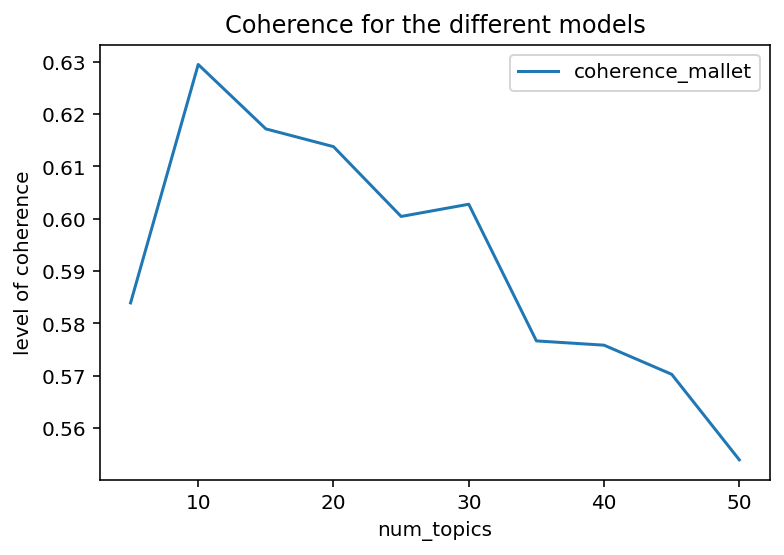

In [ ]:
mycorpus_bow = [D.doc2bow(doc) for doc in mycorpus]

# choosing the number of topics with the new data
n_topics = list(range(5,55,5))
top_coh_mall_dict = {"coherence_mallet":[], "num_topics":n_topics}
for n in n_topics:
  ldamallet = LdaMallet(mallet_path, corpus=mycorpus_bow, num_topics=n, id2word=D, alpha=5, iterations=100)
  ldagensim = malletmodel2ldamodel(ldamallet)
  coherencemodel = CoherenceModel(ldagensim, texts=mycorpus, dictionary=D, coherence='c_v')
  top_coh_mall_dict["coherence_mallet"] += [coherencemodel.get_coherence()]

top_coh_df = pd.DataFrame(top_coh_mall_dict)
display(top_coh_df)
# plotting to compare the results
top_coh_df.plot(x="num_topics");
plt.title("Coherence for the different models")
plt.ylabel("level of coherence");

Observing the results obtained we are going to choose 10 as the number of topics, which is the one that has achieved the highest coherence and analyze the results by plotting the most relevant words in each obtained topic.

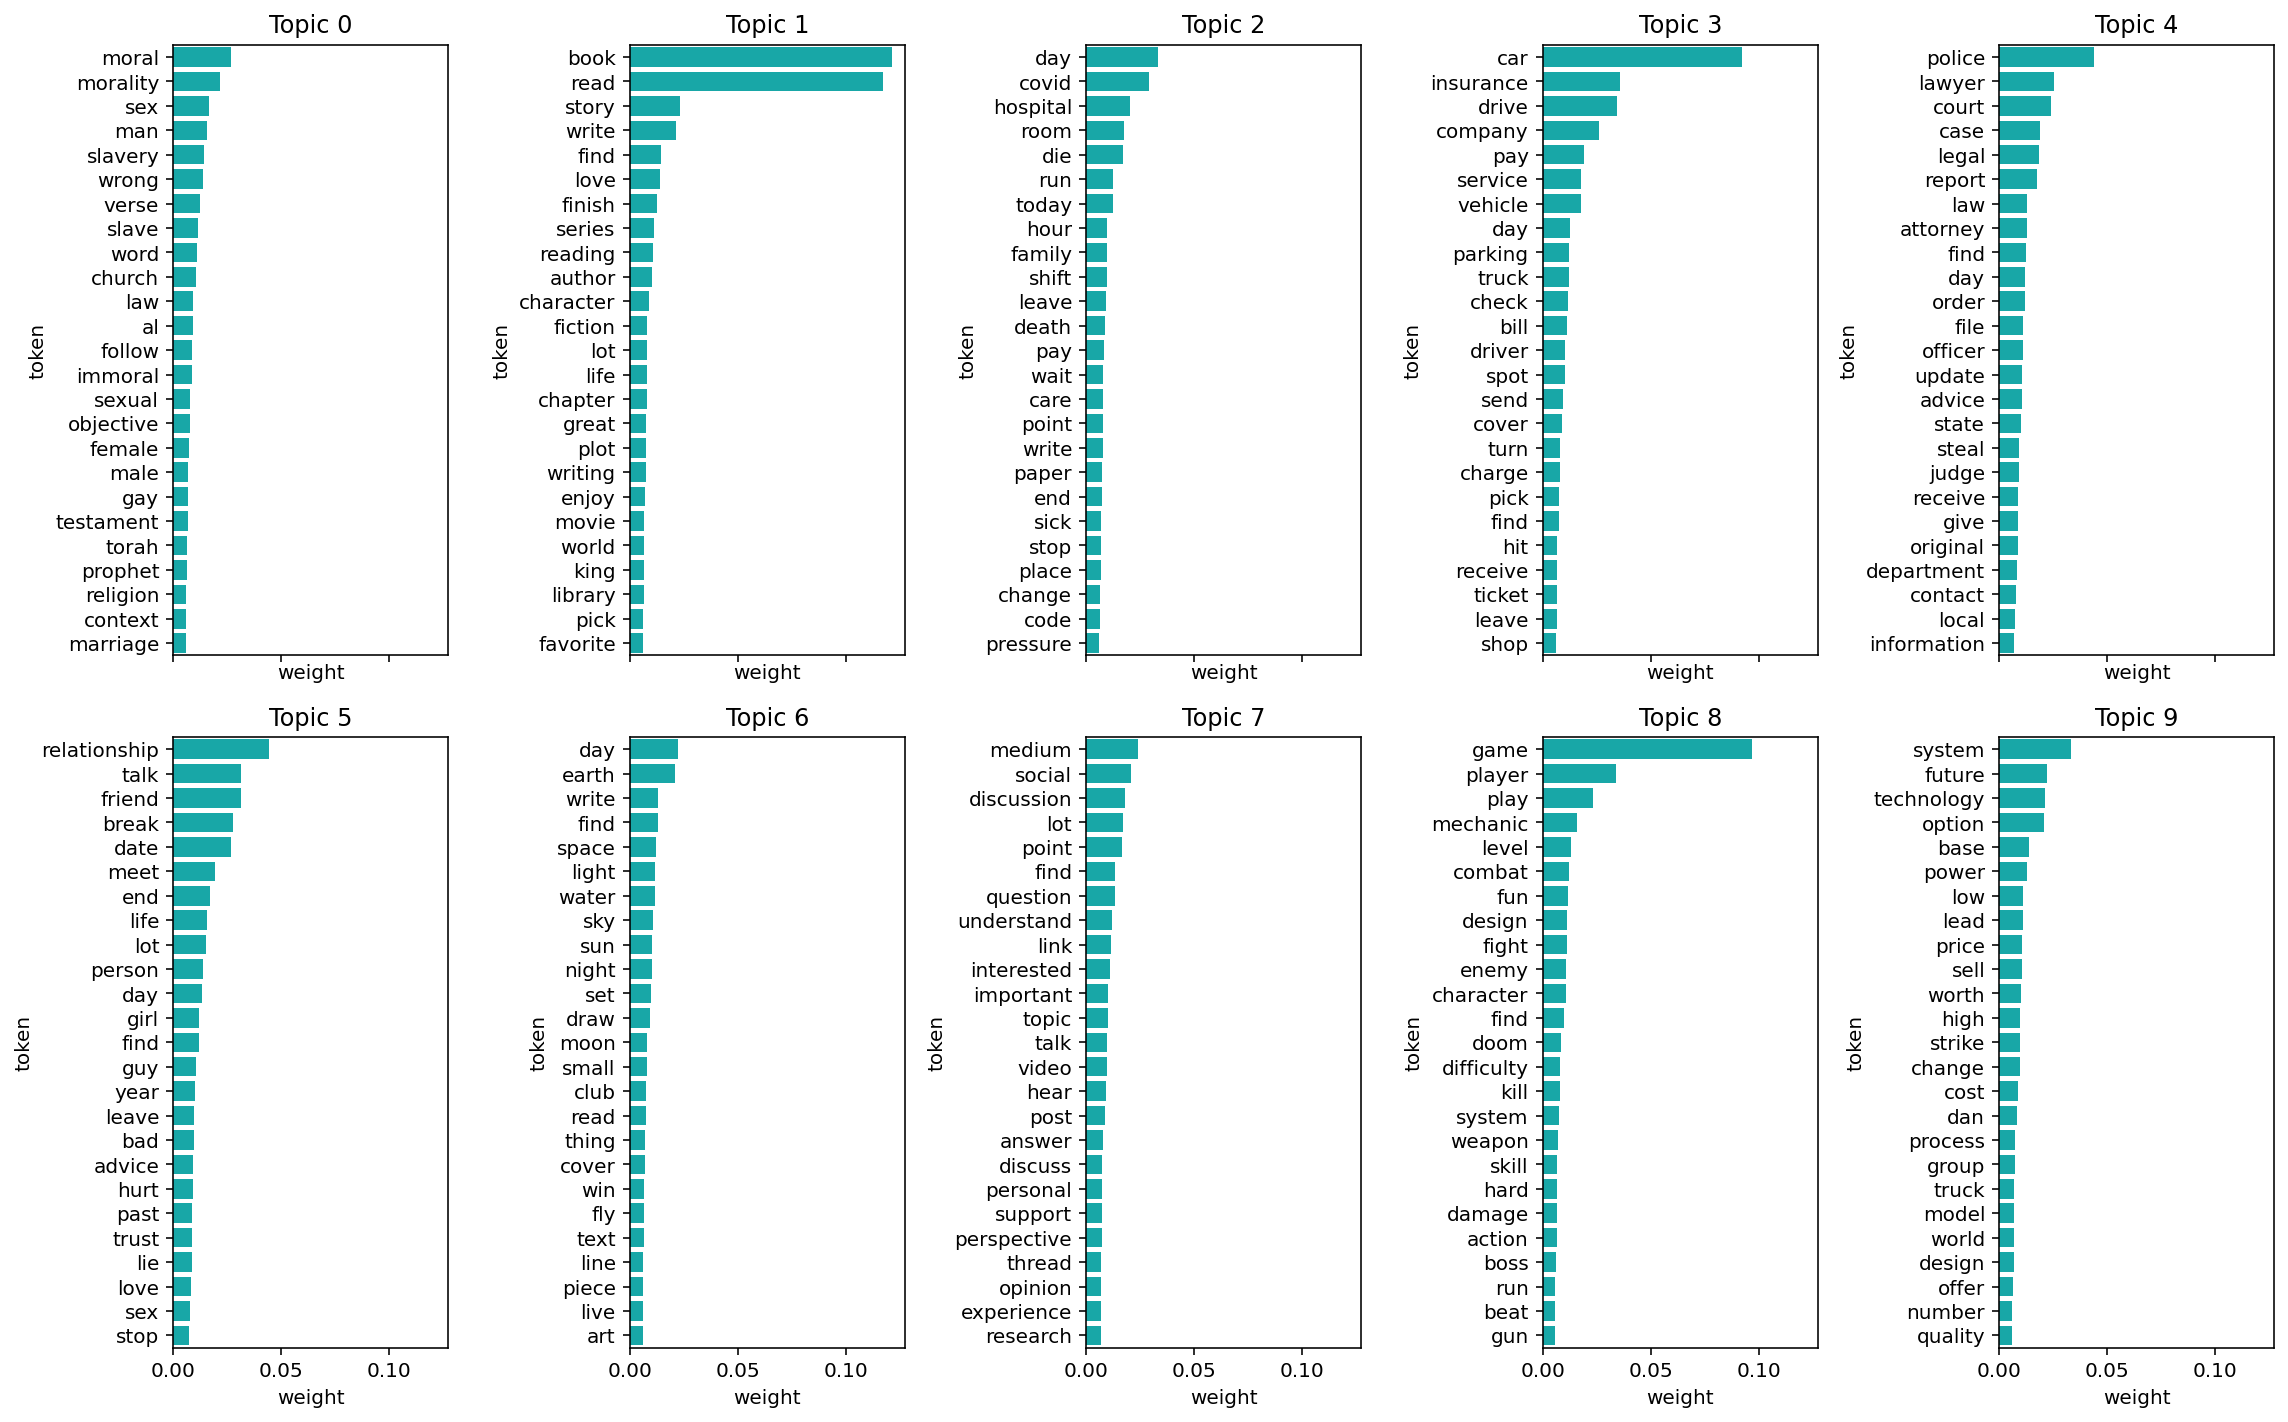

In [ ]:
ntopics = 10
from subplotted import subplotted
topn = 25
for fig,ax,i in subplotted(ntopics,ncols=5,figsize=(16,ntopics),sharex=True):
    # Build a dataframe with columns 'token' and 'weight' for topic i
    df = pd.DataFrame(ldamallet.show_topic(i, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=ax)
    ax.set_title('Topic ' + str(i))
plt.tight_layout()
plt.show()

We can clearly see a relationship between some of the topics assigned and the subjects of subreddits like `r/DataScience`, `r/DebateReligion` and `r/Medicine` so the model does seems to be somewhat coherent but we've also trained many LDA model iterations with different topics and ran into many instance of what we can consider "garbage topics" filled with relevant words that dont have a lot of meaning or correlation. 

We now want to see how good we can get by furtherly cleaning the vocabulary and removing stopwords that are specific to the dataset.  After this filtering we will analyse the relation between the topics obtained by the model and the forums in the dataset.

#### 2.4.2 Final Topic Modeling

The  Final Topic Model includes a more **advanced cleaning of the vocabulary** by  removing specific stopwords that we've manually searched and selected by analyzing the dataset and the domain of the vocabulary of each forum and **we've also increased the number of iterations to obtain a more accurate solution.** 

##### **Cleaning the vocabulary:**

In [ ]:
specific_stw = set(['relevant', 'simple', 'base','na','edit','tldr','user','comment','post']) 
specific_stw = list(specific_stw) + \
  list(common_frequents) + \
  ['people', 'experience', 'good', 'start', #manually selected stopwords
  'find','lot','year', 'high','short','low',
   'long','large','term','thing','point',
  'idea','hour', 'make','bad','big','interest',
  'person','happen','change','world','choice',
   'effect','thought','understand','day','give',
   'write','run','area','water','small','place',
   'set','big','fast','change','stuff','move','hand',
   'light','fly','leave','add','build','line','time','body',
   'stick','size','wall','eye','black','red','number','man'
   "mark","water","fact","place","future","speak","sun",
   "form","event","middle","turn","walk","room","great",
   "wear","travel","head","fire","hit","today","lose",
   "entire","watch","cross","throw","easy",
   "week","sit","stop","bit","wait","nice",
   ]

#We remove duplicates
specific_stw = list(set(specific_stw))

In [ ]:
# Add new column of lemmas with the specific stopwords removed
reddit_df['clean_lemmas'] = reddit_df['lemmas'].apply(lambda doc: " ".join([l for l in doc.split() if l not in specific_stw]))
# Recalculate the number of lemmas for each post
reddit_df['nlemmas'] = reddit_df["clean_lemmas"].str.split(" ").str.len()
# Remove posts whose number of lemmas (after specific stopword removal) is below the predefined threshold
reddit_df = reddit_df[reddit_df['nlemmas']>=MIN_LEMMAS]
print('Number of projects in DataFrame after applying specific stopwords and removing short texts:', len(reddit_df))

Number of projects in DataFrame after applying specific stopwords and removing short texts: 11378


In [ ]:
# Creating the new vocabulary
mycorpus = reddit_df.clean_lemmas.tolist()
mycorpus = [el.split() for el in mycorpus]

#new n-grams
phrase_model = Phrases(mycorpus, min_count=2, threshold=500)
mycorpus = [doc_ngram for doc_ngram in phrase_model[mycorpus]]

# Create new dictionary of tokens
D = gensim.corpora.Dictionary(mycorpus)
n_tokens = len(D)

no_below = 5 #Minimum number of documents to keep a term in the dictionary
no_above = .4 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(no_below=no_below,no_above=no_above, keep_n=25000)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

The dictionary contains 9499 terms


In [ ]:
#save both the df and the new vocabulary
local_folder = 'data/'
reddit_df.to_excel(local_folder + 'REDDIT_lemmas_df.xlsx', index=False)
D.save(local_folder + 'clean_gensim.dict')
#manager.sync_bucket()

##### **Final validation of the number of topics**

,coherence_mallet,num_topics
0,0.583903,5
1,0.629468,10
2,0.617158,15
3,0.613766,20
4,0.600424,25
5,0.602760,30
6,0.576640,35
7,0.575824,40
8,0.570260,45
9,0.553911,50


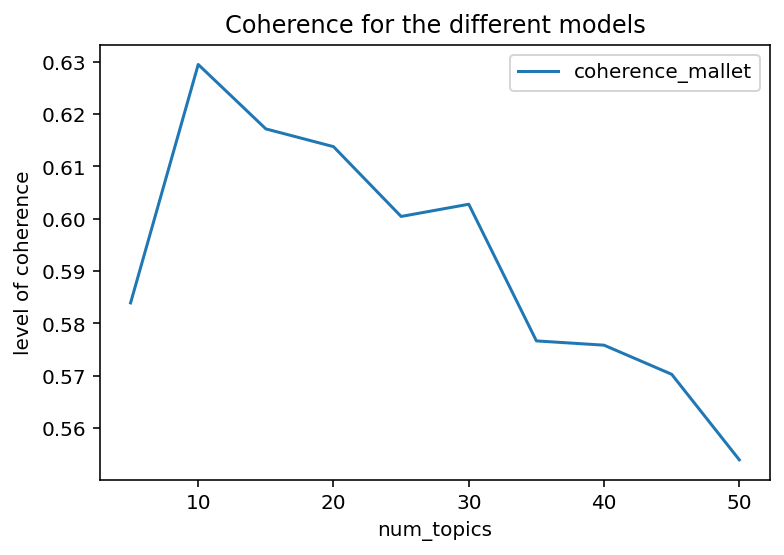

In [ ]:
mycorpus_bow = [D.doc2bow(doc) for doc in mycorpus]

# choosing the number of topics with the new data
n_topics = list(range(5,55,5))
top_coh_mall_dict = {"coherence_mallet":[], "num_topics":n_topics}
for n in n_topics:
  ldamallet = LdaMallet(mallet_path, corpus=mycorpus_bow, num_topics=n, id2word=D, alpha=5, iterations=100)
  ldagensim = malletmodel2ldamodel(ldamallet)
  coherencemodel = CoherenceModel(ldagensim, texts=mycorpus, dictionary=D, coherence='c_v')
  top_coh_mall_dict["coherence_mallet"] += [coherencemodel.get_coherence()]

top_coh_df = pd.DataFrame(top_coh_mall_dict)
display(top_coh_df)
# plotting to compare the results
top_coh_df.plot(x="num_topics");
plt.title("Evolution of model coherence with num_topics")
plt.ylabel("level of coherence");

Similar as the previous coherence analysis, we'll use 10 topics as the parameter for our LDA model based on the above results. Notice that the coherence model has confirmed our assumptions that the best number of topics to choose is related to the number of forums in the dataset, as such, we expect that the topics obtained by the final model are related to the topic of conversation of those forums.

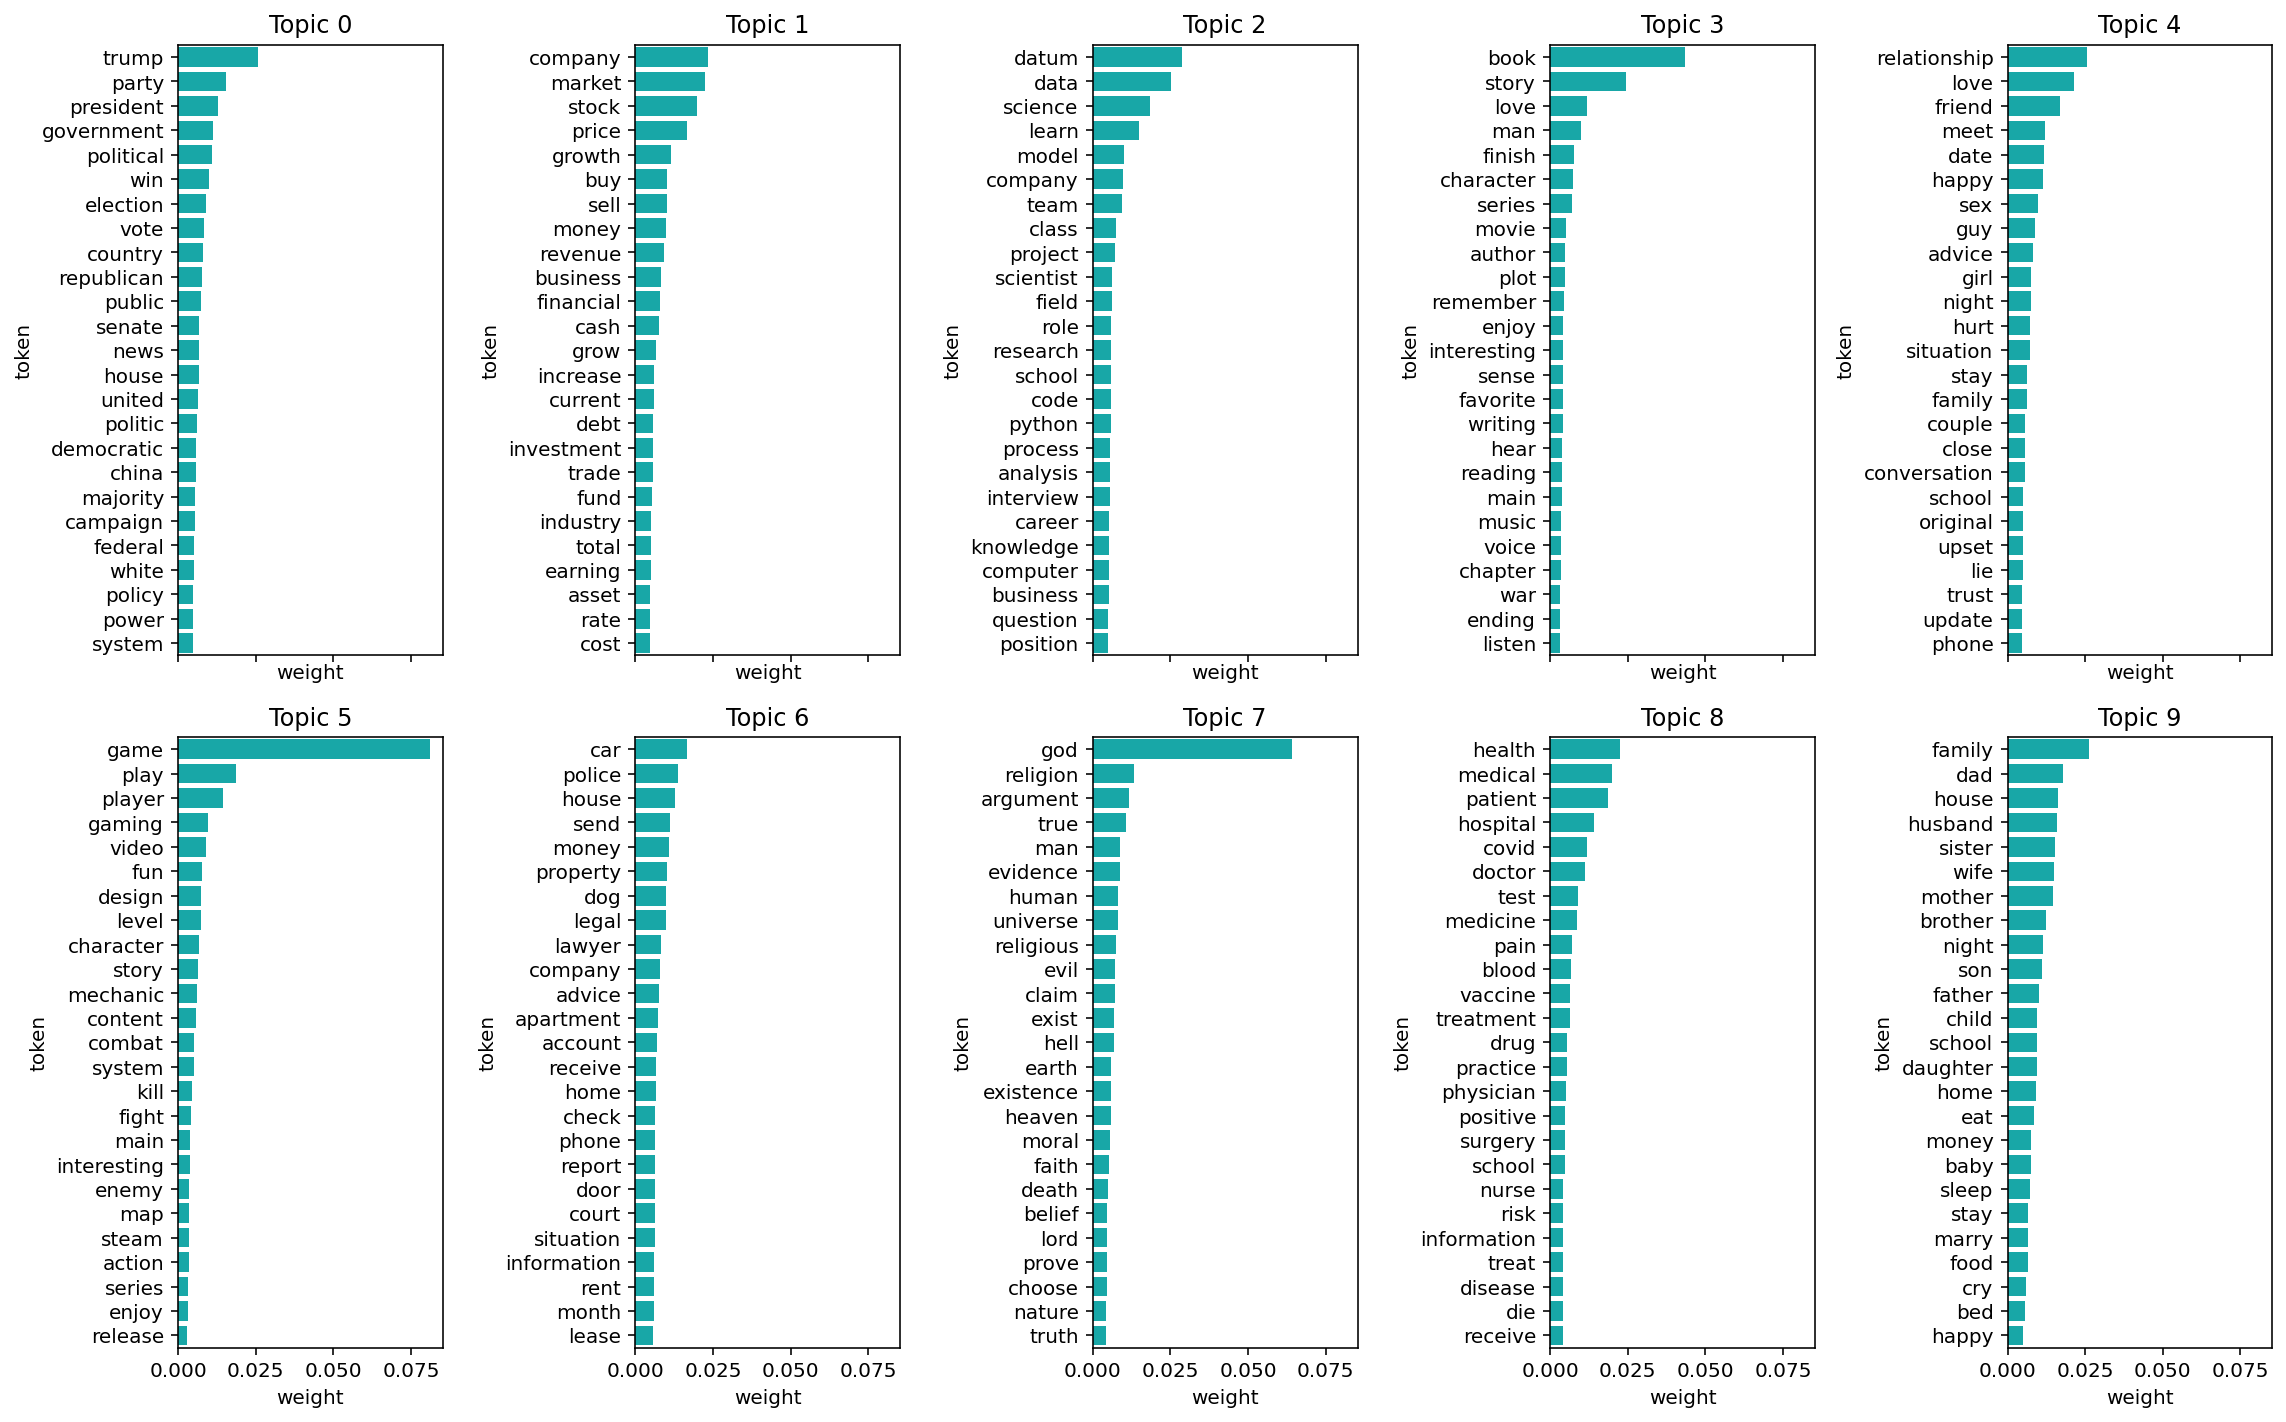

In [ ]:
from gensim.models.wrappers import LdaMallet
from subplotted import subplotted

mycorpus_bow = [D.doc2bow(doc) for doc in mycorpus]
ldamallet = LdaMallet(mallet_path, corpus=mycorpus_bow, num_topics=10, id2word=D, alpha=5, iterations=1000,random_seed=42)
topn = 25
for fig,ax,i in subplotted(ntopics,ncols=5,figsize=(16,ntopics),sharex=True):
    # Build a dataframe with columns 'token' and 'weight' for topic i
    df = pd.DataFrame(ldamallet.show_topic(i, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=ax)
    ax.set_title('Topic ' + str(i))
plt.tight_layout()
plt.show()

We can clearly see a relationship between the topics obtained and the forums. To make it more obvious we'll manually assign to each topic obtained what we thing is its equivalent name from the subreddits that we've scrapped the documents from.

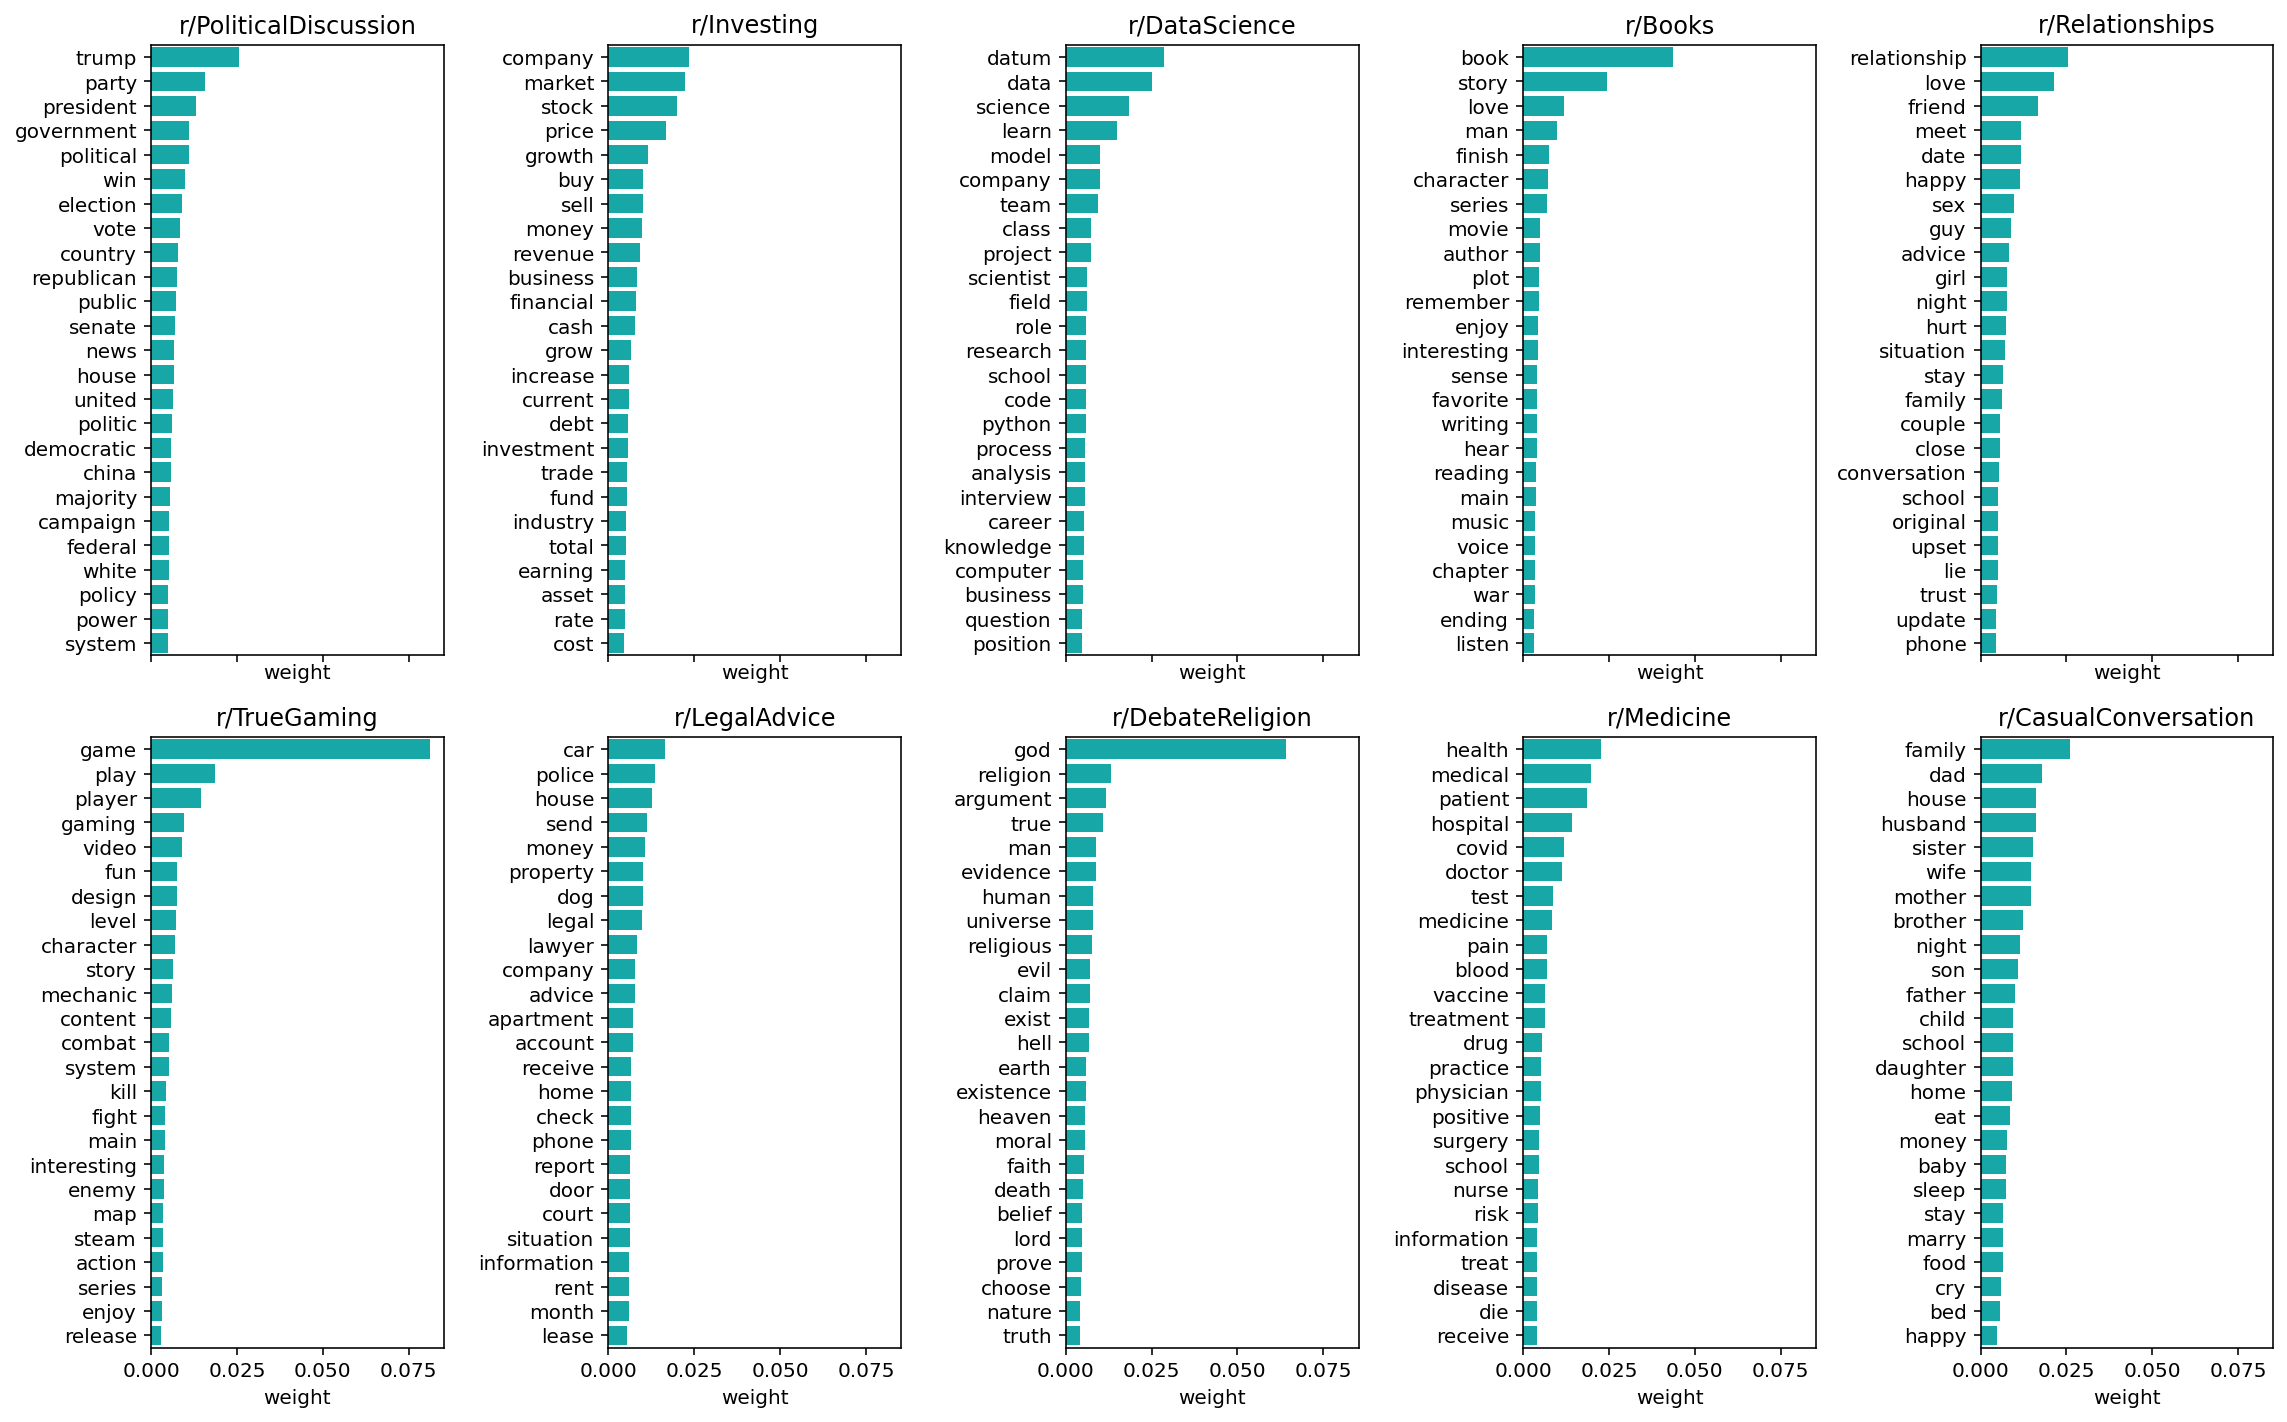

In [ ]:
#assigned by inspection of the results above
topic_names = ['PoliticalDiscussion','Investing','DataScience','Books','Relationships','TrueGaming','LegalAdvice','DebateReligion','Medicine','CasualConversation']
for fig,ax,i in subplotted(10,ncols=5,figsize=(16,10),sharex=True):
    # Build a dataframe with columns 'token' and 'weight' for topic i
    df = pd.DataFrame(ldamallet.show_topic(i, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=ax)
    ax.set(title='r/'+topic_names[i],ylabel=None)
fig.tight_layout()
plt.show()

Finally, we can visualize the final LDA model

In [ ]:
%%capture
import pyLDAvis.gensim as gensimvis
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel
import pyLDAvis

ldagensim = malletmodel2ldamodel(ldamallet)
vis_data = gensimvis.prepare(ldagensim, mycorpus_bow, D)

In [ ]:
pyLDAvis.display(vis_data)

#### *2.5.LDA representation of the documents*

We will add to each document/post in our dataset a column of of its LDA representation in order to use it in the next task of the project.

In [ ]:
mycorpus_bow = [D.doc2bow(doc) for doc in mycorpus]
mycorpus_lda = [ldagensim[el] for el in mycorpus_bow]
reddit_df['LDA'] = mycorpus_lda

In [ ]:
reddit_df[['title','subreddit','LDA']].sample(500)

,title,subreddit,LDA_assigned_topic
9676,What to to if you are proud of something but n...,CasualConversation,DataScience
8657,"In a typical relationship, how much time is no...",relationships,LegalAdvice
7810,I [38M] am a sober addict. After years of not ...,relationships,CasualConversation
2134,Home purchase slows down career progress?,datascience,DataScience
4953,If a child trapped in a burning building and p...,DebateReligion,DebateReligion
...,...,...,...
5237,"If the Quran should be read only in Arabic, th...",DebateReligion,DebateReligion
222,Do we have a moral obligation to break the wal...,medicine,Medicine
541,Concerned With The Actions Of This Doctor,medicine,Medicine
8154,How do I (mid20s) handle my girlfriend's (earl...,relationships,Relationships


Save this dataset:

In [ ]:
reddit_df.to_excel(local_folder + 'REDDIT_df_topics.xlsx', index=False)
# manager.sync_bucket()

## **3. Graph Visualization with Gephi**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
reddit_df = pd.read_excel('https://storage.googleapis.com/enver-bucket/data/REDDIT_df_topics.xlsx')
local_folder = 'data/'

### **3.1. Obtaining csv files to describe the nodes**

In [76]:
sample_size = 2000
print('Creating sample for a graph with', sample_size, 'nodes')
df_sample = reddit_df.sample(sample_size)
df_sample['Id'] = [el for el in np.arange(sample_size)]

Creating sample for a graph with 2000 nodes


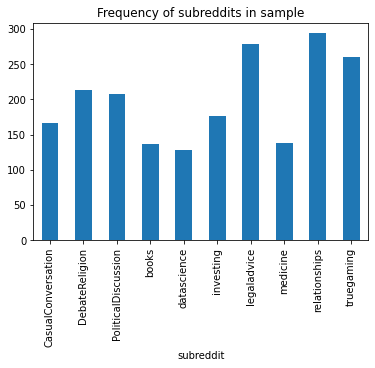

In [77]:
df_sample.groupby("subreddit").count().Id.plot.bar().set(title="Frequency of subreddits in sample");
#download as csv file
df_sample[['Id', 'title', 'subreddit', 'score']].to_csv(local_folder + 'REDDIT_nodes.csv', index=False) 

### **3.2. Obtaining csv file to describe the weights of the graph links**

Ratio of non-zero components in the similarity matrix: 0.9983985


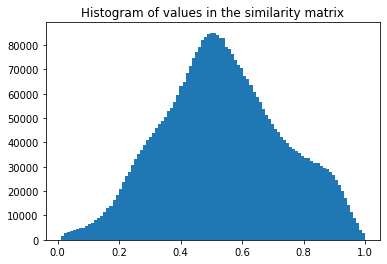

In [44]:
from gensim.matutils import corpus2csc
from scipy.sparse import triu
from ast import literal_eval

X = [literal_eval(str(el)) for el in df_sample['LDA_10'].values.tolist() ]
X = corpus2csc(X)
sqrtX = np.sqrt(X)
simmat = sqrtX.T.dot(sqrtX)

print('Ratio of non-zero components in the similarity matrix:', len(simmat.data)/simmat.shape[0]/simmat.shape[1])
plt.hist(simmat.data, bins=100)
plt.title("Histogram of values in the similarity matrix")
plt.show()


Since the histogram seems to have a normal shape with most of the links having weights in the middle we will only take those in the higher end of the tail. That is, we'll set up a high threshold in order to filter most of the links that have a lower relevance. Based on the histogram and the amount of links that Gephi can handle in our computers we've gone with a threshold of 0.85. 

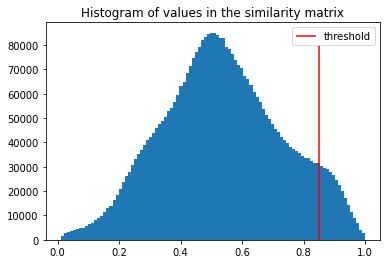

Number of links in sampled corpus: 139549


In [45]:
thr = 0.85
plt.hist(simmat.data, bins=100)
plt.title("Histogram of values in the similarity matrix")
plt.vlines(thr,0,80000,color="red",label="threshold")
plt.legend()
plt.show()
simmat.data = np.where(simmat.data < thr, 0, simmat.data)
simmat.eliminate_zeros()
simmat = triu(simmat, k=1) #Matrix is symmetric. Keep only triangular part
print('Number of links in sampled corpus:', len(simmat.data))
simmat = simmat.tocoo()

In [69]:
#download as csv file
pd.DataFrame([el for el in zip(simmat.row.tolist(),simmat.col.tolist(),simmat.data.tolist())],
             columns=['Source','Target','Weight']).to_csv(local_folder + 'REDDIT_edges.csv', index=False)

In [74]:
#!pip install git+git://github.com/simonsanvil/GoogleBucketManager.git
# from googleBucketManager import GoogleBucketManager
# manager = GoogleBucketManager()

# manager.upload_blob("data/REDDIT_nodes.csv","data/REDDIT_nodes.csv")
# nodes = manager.get_blob("data/REDDIT_nodes.csv")
# nodes.make_public()
# print("Nodes file link:",nodes.public_url)

# manager.upload_blob("data/REDDIT_edges.csv","data/REDDIT_edges.csv")
# edges = manager.get_blob("data/REDDIT_edges.csv")
# edges.make_public()
# print("Edges file link:",edges.public_url)

File data/REDDIT_nodes.csv uploaded to data/REDDIT_nodes.csv (public: True).
Nodes file link: https://storage.googleapis.com/enver-bucket/data/REDDIT_nodes.csv
File data/REDDIT_edges.csv uploaded to data/REDDIT_edges.csv (public: True).
Edges file link: https://storage.googleapis.com/enver-bucket/data/REDDIT_edges.csv


### 3.3 Graph Visualization:

From the files obtained above, we have created a graph representation of the sematic similarity of the 2000 random sample of reddits posts in our dataset using Gephi. Each of the nodes represents a document and the edges the semantic distance between the pair of documents.

[TEXTO DE ANDRES]

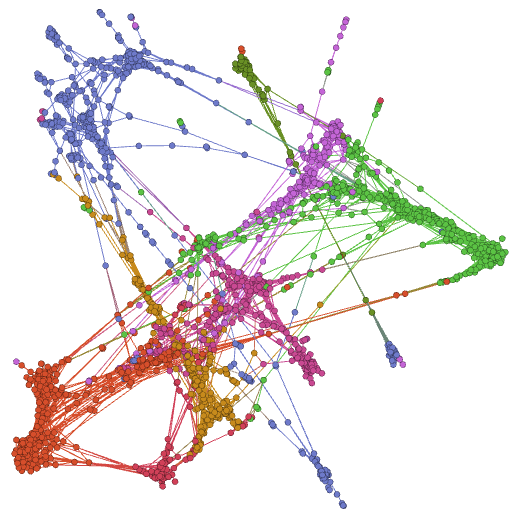